In [1]:
import keras
# weight = 모델 초기화 가중치 체크포인트 지정
# include_top 최상위 완전 연결 분류기 포함 여부(default = 완전 연결 분류기 포함)
# 우리는 별도의 강아지+고양이 클래스 구분했던 거 추가할 거니까 선택 x
# input_shape = 네트워크에 주입할 텐서 크기, 입력하지 않으면 어떤 크기든 맞춰서 처리해주는 듯
from keras.applications import VGG16
conv_base = VGG16(weights = 'imagenet',
                  include_top = False,
                  input_shape = (150, 150, 3))

Using TensorFlow backend.






58892288/58889256 [==============================] - 3s 0us/step








In [2]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## (4, 4, 512) 마지막 층 위에 완전 연결층 놓을 거임
- 새로운 dataset에서 합성곱 층 실행하고 출력을 넘파이 배열로 저장 후 데이터를 완전 연결 분류기에 입력으로 사용.
- 또는 준비된 모델 위애 Dense로 확장하고 입력 데이터에서 end to end로 전체 모델 실행
모델에 노출된 모든 입력 이미지가 매번 합성곱 기반층을 통과하기 때문에 데이터 증식 사용 가능
첫 번째보다 품이 많이 듦

In [0]:
import zipfile

In [5]:

 
try:
    with zipfile.ZipFile("/content/drive/My Drive/dataset/train.zip") as zf:
        zf.extractall('./data')
        print("uncompress success")
 
except:
    print("uncompress fail")



uncompress success


In [0]:
import os, shutil
original_dataset_dir = './data'
base_dir = './cat_and_dogs_small'
if os.path.exists(base_dir):
  shutil.rmtree(base_dir)
os.mkdir(base_dir)

# train, val, test split
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# train cat, dog dir
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# val cat, dog dir
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# test cat, dog dir
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

In [0]:
# for 1000 cat image train_cats_dir copy
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(train_cats_dir, fname)
  shutil.copyfile(src, dst)

# for 500 cat image val_cats_dir copy
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(validation_cats_dir, fname)
  shutil.copyfile(src, dst)

# for 500 cat image test_cats_dir copy
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(test_cats_dir, fname)
  shutil.copyfile(src, dst)

# for 1000 dog image train_dogs_dir copy
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(train_dogs_dir, fname)
  shutil.copyfile(src, dst)

# for 500 dog image val_dogs_dir copy
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(validation_dogs_dir, fname)
  shutil.copyfile(src, dst)

# for 500 dog image test_dogs_dir copy
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(test_dogs_dir, fname)
  shutil.copyfile(src, dst)

In [21]:
# 제대로 했는지 확인
print('train cat, dog: ', len(os.listdir(train_cats_dir)), 
      len(os.listdir(train_dogs_dir)))

train cat, dog:  1000 1000


In [22]:
# 제대로 했는지 확인
print('val cat, dog: ', len(os.listdir(validation_cats_dir)), 
      len(os.listdir(validation_dogs_dir)))

val cat, dog:  500 500


In [23]:
# 제대로 했는지 확인
print('test cat, dog: ', len(os.listdir(test_cats_dir)), 
      len(os.listdir(test_dogs_dir)))

test cat, dog:  500 500


In [24]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# train, val, test 있는 root 폴더랑 다 명시해줌
base_dir = './cat_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# 이미지를 이 gener로 갖고 올 때는 다 리스케일
datagen = ImageDataGenerator(rescale = 1./255)
# 20개씩 끊어서 갖고 옴
batch_size = 20

# 경로랑 몇 개 가져올지 입력으로 받음
def extract_features(directory, sample_count):
  # 마지막 층 거치면 이 shape가 나옴, 똑같이 만들어 줘야 값 저장 가능
  features = np.zeros(shape = (sample_count, 4, 4, 512))
  # 정답란
  labels = np.zeros(shape = (sample_count))
  # 20개씩 끊어서 갖고 옴, 바이너리 형식
  generator = datagen.flow_from_directory(
      directory,
      target_size = (150, 150),
      batch_size = batch_size,
      class_mode = 'binary')
  
  i= 0
  for inputs_batch, labels_batch in generator:
    # 나오는 결과물들을 신경망에 바로 넣어줌
    features_batch = conv_base.predict(inputs_batch)
    # 결과를 20개씩 차곡차곡 쌓아줌
    features[i * batch_size : (i + 1) * batch_size] = features_batch
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1

    # 원하는 만큼 뽑아주면 break
    if i * batch_size >= sample_count:
      break
  return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
# 어려워할 거 없음 그냥 이미지를 vgg에 한 번 넣은 거임
# 완전 연결 분류기에 주입 전 sample * 8192으로 변환
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [39]:
# fully conected layer define, and saved data + label train
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation = 'relu', input_dim = 4 * 4* 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer = optimizers.RMSprop(lr = 2e-5),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

history = model.fit(train_features, train_labels,
                    epochs = 30,
                    batch_size = 20,
                    validation_data = (validation_features, validation_labels))



Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 599us/step - loss: 0.5973 - acc: 0.6730 - val_loss: 0.4459 - val_acc: 0.8010
Epoch 2/30
2000/2000 [==============================] - 1s 423us/step - loss: 0.4306 - acc: 0.7980 - val_loss: 0.3575 - val_acc: 0.8640
Epoch 3/30
2000/2000 [==============================] - 1s 414us/step - loss: 0.3610 - acc: 0.8450 - val_loss: 0.3365 - val_acc: 0.8640
Epoch 4/30
2000/2000 [==============================] - 1s 435us/step - loss: 0.3162 - acc: 0.8650 - val_loss: 0.2983 - val_acc: 0.8850
Epoch 5/30
2000/2000 [==============================] - 1s 419us/step - loss: 0.2923 - acc: 0.8835 - val_loss: 0.2834 - val_acc: 0.8930
Epoch 6/30
2000/2000 [==============================] - 1s 426us/step - loss: 0.2626 - acc: 0.8885 - val_loss: 0.2731 - val_acc: 0.8970
Epoch 7/30
2000/2000 [==============================] - 1s 410us/step - loss: 0.2490 - acc: 0.8980 - val_loss: 0.2647 - val_acc: 0.900

In [0]:
# 디게 빠르다.
import matplotlib.pyplot as plt

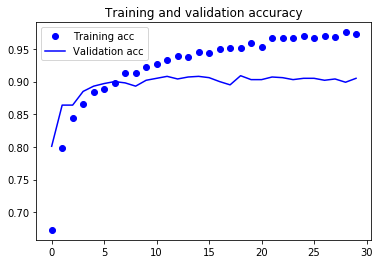

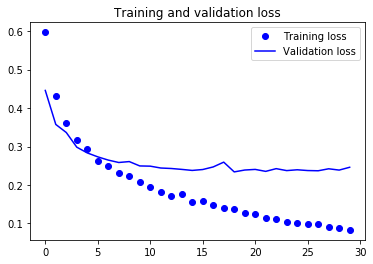

In [41]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
# 이전에 에폭 100으로 하고 이미지 변환한 거보다 더 빠르긴 하다.
# 하지만 드롭아웃을 반이나 끊어줬는데 과대적합이 된다.
# 여기서는 데이터 증식을 사용해주지 않아서 그런가 보다.

In [0]:
# 이제 두 번째 방법(vgg 아래에 완전연결분류기 정의)
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [46]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [47]:
# 훈련 전 합성곱 기반층을 밀봉하는 게 중요.
# 그렇지 않으면 미리 훈련된 합성곱 기반층과 훈련되지 않은 완전연결층이 섞임
print('conv_base 동결 전 훈련되는 가중치의 수: ', len(model.trainable_weights))

conv_base 동결 전 훈련되는 가중치의 수:  30


In [0]:
conv_base.trainable = False

In [49]:
print('conv_base 동결 후 훈련되는 가중치의 수: ', len(model.trainable_weights))

conv_base 동결 후 훈련되는 가중치의 수:  4


In [0]:
# 스위치처럼 on off 할 수 있는듯

In [55]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest')

# 검증 데이터는 학습 x
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary')

model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.RMSprop(lr = 2e-5),
              metrics = ['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch = 100,
    epochs = 30,
    validation_data = validation_generator,
    validation_steps = 50)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 27s 271ms/step - loss: 0.5642 - acc: 0.7310 - val_loss: 0.4161 - val_acc: 0.8510
Epoch 2/30
100/100 [==============================] - 25s 250ms/step - loss: 0.4052 - acc: 0.8425 - val_loss: 0.3403 - val_acc: 0.8610
Epoch 3/30
100/100 [==============================] - 25s 249ms/step - loss: 0.3526 - acc: 0.8530 - val_loss: 0.3031 - val_acc: 0.8790
Epoch 4/30
100/100 [==============================] - 25s 251ms/step - loss: 0.3256 - acc: 0.8615 - val_loss: 0.2812 - val_acc: 0.8900
Epoch 5/30
100/100 [==============================] - 25s 246ms/step - loss: 0.3068 - acc: 0.8800 - val_loss: 0.2726 - val_acc: 0.8890
Epoch 6/30
100/100 [==============================] - 24s 243ms/step - loss: 0.2884 - acc: 0.8730 - val_loss: 0.2649 - val_acc: 0.8890
Epoch 7/30
100/100 [==============================] - 25s 247ms/step - loss: 0.2803 - acc: 0.8850 - val_lo

In [56]:
model.save('cats_and_dogs_small_3.h5')
files.download('cats_and_dogs_small_3.h5')

NameError: ignored

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()